In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import scikitplot as skplt
import matplotlib.pyplot as plt
import optuna
from time import time
from datetime import datetime

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [2]:
DF_PATH = "data/lifestyle_sustainability_data_standardized.csv"

In [3]:
df_raw = pd.read_csv(DF_PATH)
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.dtypes)
df_raw.head()

(499, 13)
Index(['EnvironmentalAwareness', 'CommunityInvolvement',
       'MonthlyElectricityConsumption', 'MonthlyWaterConsumption',
       'PhysicalActivities', 'DietType_Balanced',
       'DietType_Mostly Animal-Based', 'DietType_Mostly Plant-Based',
       'TransportationMode_Bike', 'TransportationMode_Car',
       'TransportationMode_Public Transit', 'TransportationMode_Walk',
       'Rating'],
      dtype='object')
EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                             

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3


In [4]:
df_raw.groupby("Rating").size()

Rating
1     97
2     34
3    101
4     91
5    176
dtype: int64

#### Prepare X and Y

In [5]:
RANDOM_STATE = 42
test_size = 0.05 # test set
val_size = 0.1 # validation set

In [6]:
df = df_raw.copy()
df.shape

(499, 13)

In [7]:
df["Rating"] = df["Rating"].apply(lambda rating: rating - 1) # required to fit XGBoost
target_column = df.pop("Rating")
X = df.to_numpy()
Y = np.array(target_column.to_list())
X.shape, Y.shape

((499, 12), (499,))

Train/Test Split (Stratified Test)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=RANDOM_STATE) # stratified train/test
print(f"X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} | Y_test: {Y_test.shape}")
print(f"Y_test label distribution: {np.unique(Y_test, return_counts=True)}")

X_train: (474, 12) | Y_train: (474,)
X_test: (25, 12) | Y_test: (25,)
Y_test label distribution: (array([0, 1, 2, 3, 4]), array([5, 2, 5, 4, 9], dtype=int64))


---

In [9]:
number_of_splits = 5

stratified_shufflesplit = StratifiedShuffleSplit(n_splits=number_of_splits, test_size=val_size, random_state=RANDOM_STATE)
stratified_shufflesplit

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None)

In [10]:
score_metric = "roc_auc_ovo" # ROC-AUC One-vs-One Approach

### Random Forest

In [11]:
def objective_rf(trial: optuna.Trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 150, log=True)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 6, log=True)
    rf_max_features = trial.suggest_int("rf_max_features", 2, X.shape[1], log=True)
    classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, max_features=rf_max_features)
    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=score_metric, n_jobs=-1, cv=stratified_shufflesplit, verbose=1)
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [12]:
n_trials = 50

In [13]:
timestamp = datetime.fromtimestamp(time()).strftime("%Y-%m-%d_%H:%M:%S")

study = optuna.create_study(storage="sqlite:///db.sqlite3", study_name=f"RandomForest_ntrials={n_trials}_{timestamp}", direction="maximize")
study.optimize(objective_rf, n_trials=n_trials, n_jobs=-1)

[I 2024-12-24 13:28:09,886] A new study created in RDB with name: RandomForest_ntrials=50_2024-12-24_13:28:09
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBa

In [14]:
study.best_params, study.best_value

({'rf_n_estimators': 149, 'rf_max_depth': 4, 'rf_max_features': 3},
 0.9187690631808281)

In [15]:
best_rf_model = RandomForestClassifier(
    n_estimators = study.best_params["rf_n_estimators"],
    max_depth = study.best_params["rf_max_depth"],
    max_features = study.best_params["rf_max_features"])
best_rf_model

RandomForestClassifier(max_depth=4, max_features=3, n_estimators=149)

In [16]:
best_rf_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=4, max_features=3, n_estimators=149)

#### Results of Test Split

In [17]:
Y_test_predicted_proba_rf = best_rf_model.predict_proba(X_test)
len(Y_test_predicted_proba_rf), Y_test_predicted_proba_rf[:2]

(25,
 array([[0.05819844, 0.04281325, 0.1079017 , 0.2409325 , 0.55015411],
        [0.01126111, 0.01118863, 0.0407233 , 0.21137644, 0.72545053]]))

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


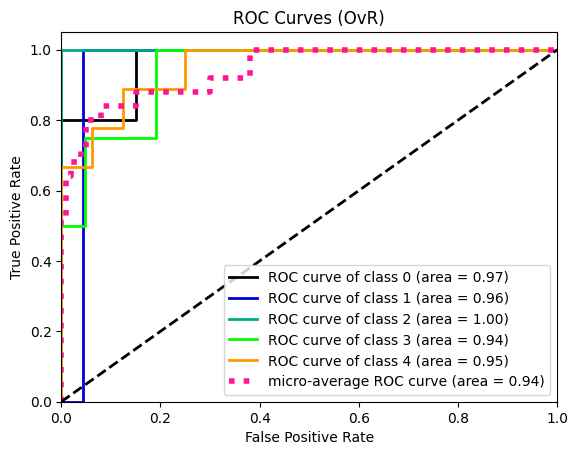

In [18]:
skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_rf, title="ROC Curves (OvR)", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
plt.show()

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


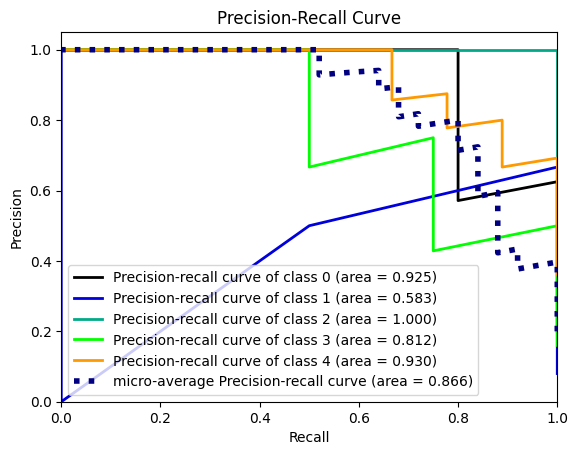

In [19]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_rf)
plt.show()

### XGBoost

In [20]:
def objective_xgb(trial= optuna.Trial):
    xgb_gamma = trial.suggest_float("xgb_gamma", 0, 0.5, step=0.01)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.5, step=0.01)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 6, log=True)
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 50, 150, log=True)
    classifier_obj = xgb.XGBClassifier(objective='multi:softprob', gamma=xgb_gamma, learning_rate=xgb_learning_rate, 
                                       max_depth=xgb_max_depth, n_estimators=xgb_n_estimators) # XGBClassifier for multi-class classification
    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=score_metric, n_jobs=-1, cv=stratified_shufflesplit, verbose=1)
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [21]:
param_combinations_xgb = 50

In [22]:
timestamp = datetime.fromtimestamp(time()).strftime("%Y-%m-%d_%H:%M:%S")

study = optuna.create_study(storage="sqlite:///db.sqlite3", study_name=f"XGBoost_ntrials={param_combinations_xgb}_{timestamp}", direction="maximize")
study.optimize(objective_xgb, n_trials=param_combinations_xgb, n_jobs=-1)

[I 2024-12-24 13:28:54,659] A new study created in RDB with name: XGBoost_ntrials=50_2024-12-24_13:28:54
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

In [23]:
study.best_params, study.best_value

({'xgb_gamma': 0.37,
  'xgb_learning_rate': 0.28,
  'xgb_max_depth': 2,
  'xgb_n_estimators': 117},
 0.9137400145243284)

In [24]:
best_xgb_model = xgb.XGBClassifier(objective='multi:softprob', 
                                   gamma=study.best_params["xgb_gamma"], learning_rate=study.best_params["xgb_learning_rate"], 
                                   max_depth=study.best_params["xgb_max_depth"], n_estimators=study.best_params["xgb_n_estimators"])
best_xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.37, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.28, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=117, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
best_xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.37, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.28, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=117, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

#### Results on Test Split

In [26]:
Y_test_predicted_proba_xgb = best_xgb_model.predict_proba(X_test)
len(Y_test_predicted_proba_xgb), Y_test_predicted_proba_xgb[:2]

(25,
 array([[0.01295138, 0.01828798, 0.04078467, 0.25208932, 0.67588663],
        [0.00343093, 0.00348597, 0.01017686, 0.19460472, 0.7883015 ]],
       dtype=float32))

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


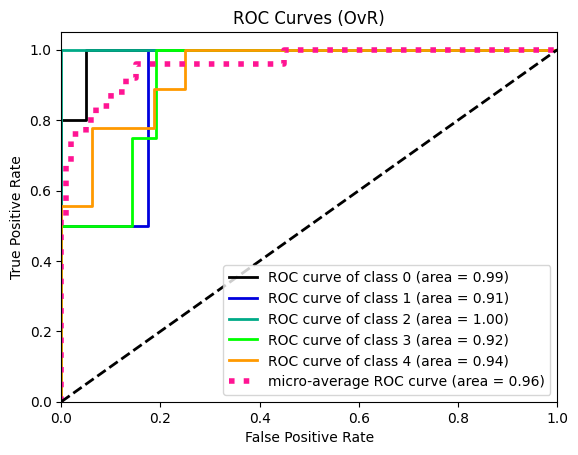

In [27]:
skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_xgb, title="ROC Curves (OvR)", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
plt.show()

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


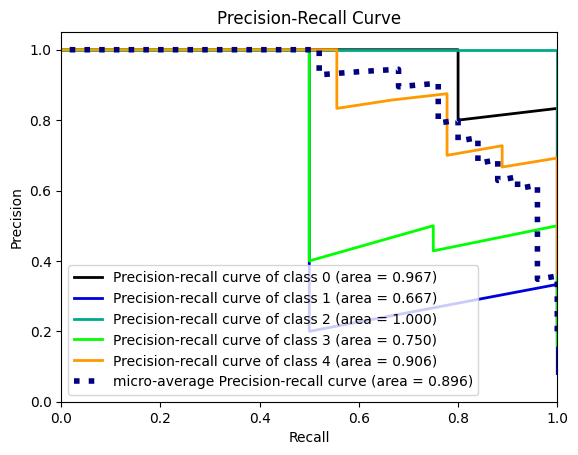

In [28]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_xgb)
plt.show()

#### Feature Importance

In [29]:
for index, feature in enumerate(df.columns):
    print(f"f{index}: {feature}")

f0: EnvironmentalAwareness
f1: CommunityInvolvement
f2: MonthlyElectricityConsumption
f3: MonthlyWaterConsumption
f4: PhysicalActivities
f5: DietType_Balanced
f6: DietType_Mostly Animal-Based
f7: DietType_Mostly Plant-Based
f8: TransportationMode_Bike
f9: TransportationMode_Car
f10: TransportationMode_Public Transit
f11: TransportationMode_Walk


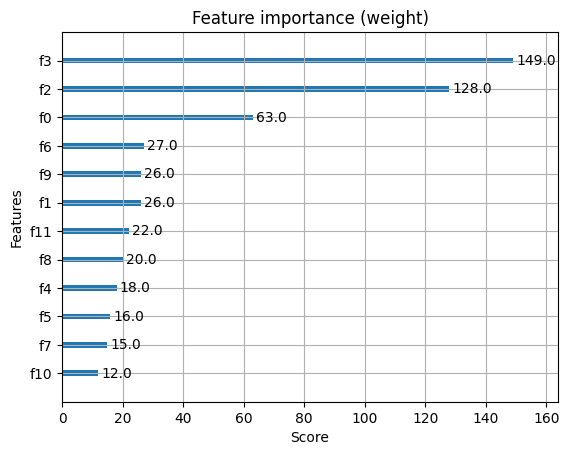

In [30]:
xgb.plot_importance(best_xgb_model, importance_type="weight", title="Feature importance (weight)", xlabel="Score")
plt.show()

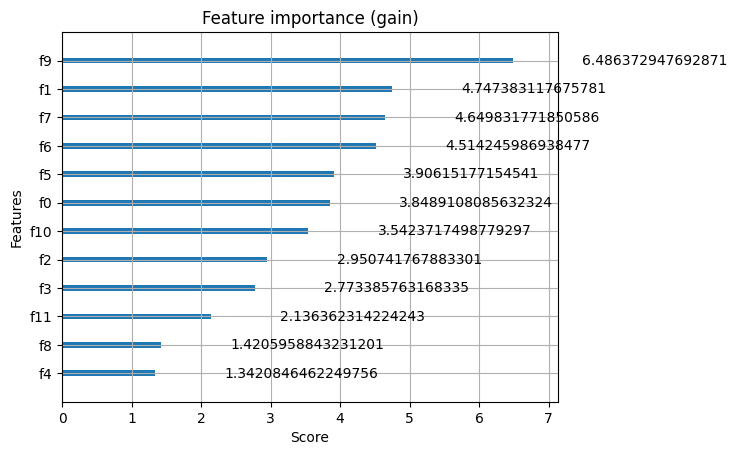

In [31]:
xgb.plot_importance(best_xgb_model, importance_type="gain", title="Feature importance (gain)", xlabel="Score")
plt.show()